In [1]:
import pandas as pd
import numpy as np
from graspologic.embed import ClassicalMDS
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import RBFInterpolator, LinearNDInterpolator

from tqdm import tqdm

%matplotlib inline

/cis/home/adesilva/.conda/envs/llm2/lib/python3.9/site-packages/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


In [2]:
fisher_data_file_path = '../data/contexts.xlsx'
fisher_data = pd.read_excel(fisher_data_file_path)
strings = fisher_data['string']
labels = fisher_data['label']
C = np.array([0 if ell=='statistics' else 1 for ell in labels])

In [3]:
import pickle

embeddings_and_phats = pickle.load(open('embeddings_and_phats_with_paired_appendix.p', 'rb'))
embeddings_dict = embeddings_and_phats['embeddings']
phats_dict = embeddings_and_phats['phats']

In [4]:
base_embeddings = []
for str, embds in embeddings_dict[0].items():
    base_embeddings += embds
base_embeddings = np.array(base_embeddings)
base_cmds = ClassicalMDS(n_components=2).fit_transform(base_embeddings)

In [5]:
from scipy.spatial import procrustes

strings = list(embeddings_dict[0].keys())
n_perturbations = len(embeddings_dict[1][strings[0]])

length_list = list(np.sort(list(embeddings_dict.keys())))

embedding_distances_dict = {}

cmds_embds = {}
cmds_embds[0] = {}

for length in tqdm(length_list[1:]):
    embedding_distances_dict[length] = []
    cmds_embds[length] = {}
    for mc in range(n_perturbations):
        temp_embeddings = []
        
        for s in embeddings_dict[length]:
            temp_embeddings.append(embeddings_dict[length][s][mc])
            
        temp_embeddings = np.array(temp_embeddings)
        temp_cmds = ClassicalMDS(n_components=2).fit_transform(temp_embeddings)

        mtx1, mtx2, d = procrustes(base_cmds, temp_cmds)
        cmds_embds[length][mc] = mtx2

        if length == length_list[1]:
            if mc == 0:
                cmds_embds[0][0] = mtx1
        
        embedding_distances_dict[length].append(np.linalg.norm(mtx1 - mtx2))

100%|██████████| 4/4 [00:46<00:00, 11.71s/it]


In [16]:
n_perturbations

10

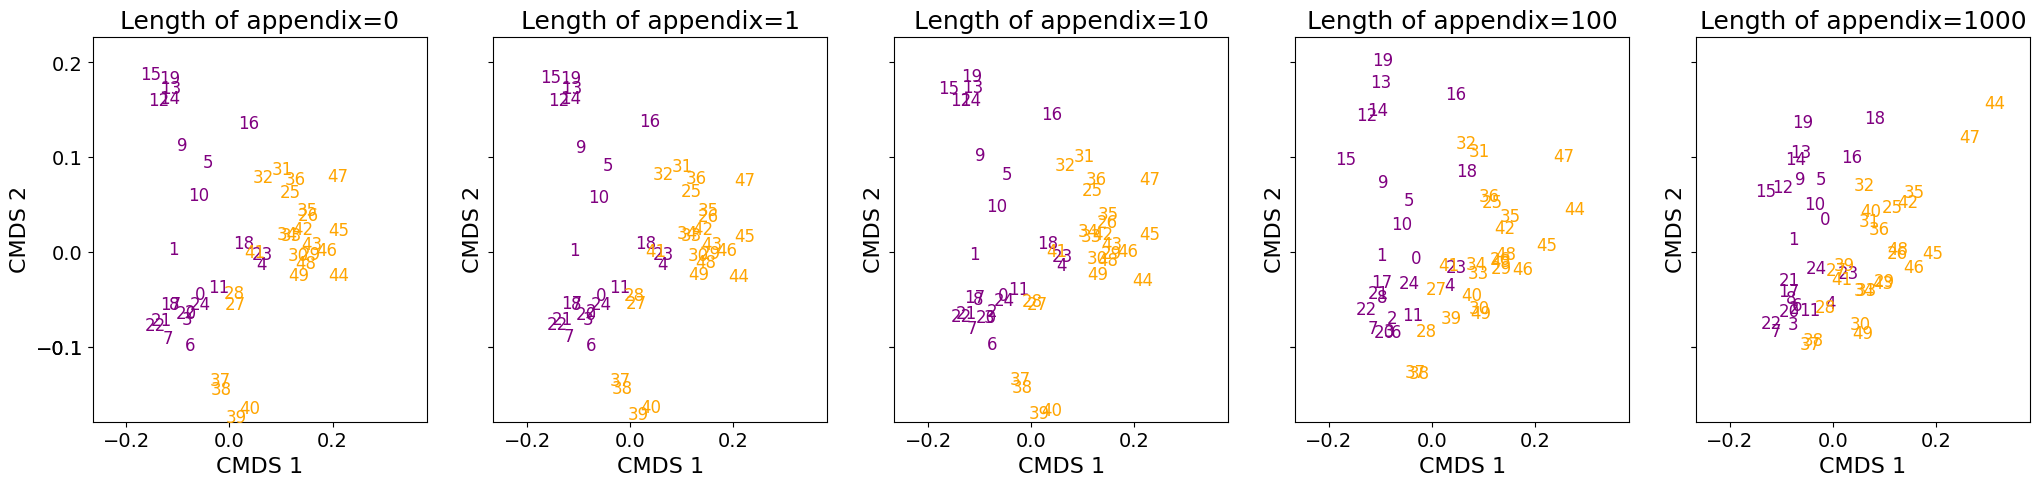

In [6]:
import seaborn as sns

colors = sns.color_palette("Set1", n_colors=2)
colors = ["purple", "orange"]
fig, ax = plt.subplots(1, 5, figsize=(25,5), sharex=True, sharey=True)

for ii, p in enumerate(length_list):
    for i in range(50):
        ax[ii].text(cmds_embds[p][0][i, 0], cmds_embds[p][0][i, 1], s=i, fontsize=12, c=colors[C[i]])

    miny = np.min(cmds_embds[p][0][:, 1])
    maxy = np.max(cmds_embds[p][0][:, 1])
    
    minx = np.min(cmds_embds[p][0][:, 0])
    maxx = np.max(cmds_embds[p][0][:, 0])
    
    ax[ii].set_xlim(minx - 0.75*abs(minx), maxx + 0.3*abs(maxx))
    ax[ii].set_ylim(miny - 0.75*abs(miny), maxy + 0.5*abs(maxy))

    ax[ii].set_title(f'Length of appendix={p}', fontsize=18)
    ax[ii].set_ylabel('CMDS 2', fontsize=16)
    ax[ii].set_xlabel('CMDS 1', fontsize=16)

    ax[ii].set_yticks([-.1, 0, -0.1, 0.1, 0.2])
    ax[ii].tick_params(labelsize=14)

Text(0.5, 1.0, 'Average L2 norm after applying Procrustes transform on Y')

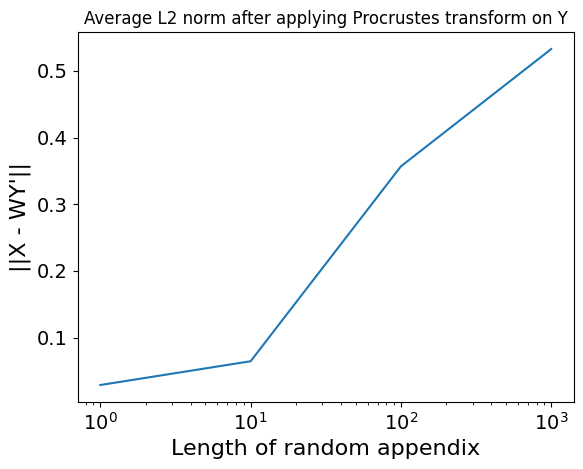

In [7]:
fig, ax = plt.subplots(1,1)
average_distances = [np.mean(v) for v in embedding_distances_dict.values()]

ax.semilogx(length_list[1:], average_distances)
ax.set_ylabel("||X - WY'||", fontsize=16)
ax.set_xlabel("Length of random appendix", fontsize=16)
ax.tick_params(labelsize=14)
ax.set_title('Average L2 norm after applying Procrustes transform on Y')

In [8]:
base_phats = np.array(list(phats_dict[0].values()))[:,0]
phats_by_mc = {}

for length in tqdm(length_list):
    phats_by_mc[length] = {}
    for mc in range(n_perturbations):
        if length==0 and mc > 0:
            continue
        phats_by_mc[length][mc] = []
        
        for s in phats_dict[length]:
            phats_by_mc[length][mc].append(phats_dict[length][s][mc])

    if length==0 and mc>0:
        continue
    phats_by_mc[length][mc] = np.array(phats_by_mc[length][mc])

100%|██████████| 5/5 [00:00<00:00, 2538.92it/s]


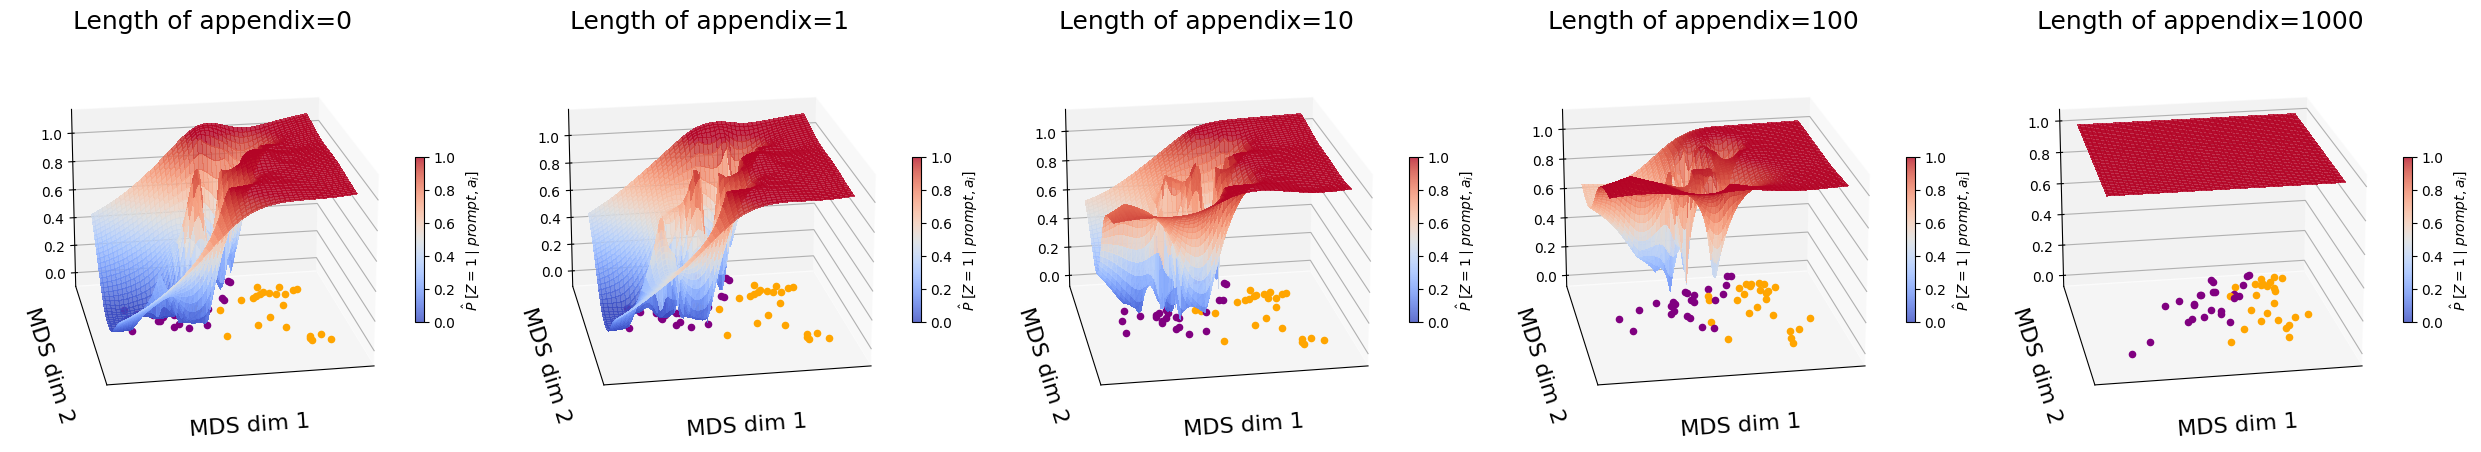

In [10]:
fig = plt.figure(figsize=(25, 5))
fig.add_gridspec(1,5, hspace=0)

for i, p in enumerate(length_list):
    phats = []
        
    phats = np.hstack(phats_by_mc[p][0])
    cmds_embds_p = cmds_embds[p][0]
    
    ax = fig.add_subplot(1, 5, i+1, projection='3d')
    
    xg, yg = np.meshgrid(cmds_embds_p[:, 0], cmds_embds_p[:, 1], indexing='ij')
    interp = RBFInterpolator(cmds_embds_p, phats, kernel='linear', smoothing=0.001)
    
    miny = np.min(cmds_embds_p[:, 1])
    maxy = np.max(cmds_embds_p[:, 1])
    
    minx = np.min(cmds_embds_p[:, 0])
    maxx = np.max(cmds_embds_p[:, 0])
    
    xx = np.linspace(minx - 0.2*abs(minx), maxx + 0.2*abs(maxx), 100)
    yy = np.linspace(miny - 0.2*abs(miny), maxy + 0.2*abs(maxy), 100)
    X, Y = np.meshgrid(xx, yy, indexing='ij')
    
    grid = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)
    vals = interp(grid)
    
    Surface = ax.plot_surface(X, Y, vals.reshape(100, 100), color='m', cmap=cm.coolwarm, antialiased=False, linewidth=0, vmin=0, vmax=1, alpha=0.8)

    cs=['purple', 'orange']
    for i in range(50):
        color=cs[C[i]-1]
        ax.scatter(cmds_embds_p[i, 0], cmds_embds_p[i, 1], 0, s=20, c=color)
    
    
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    fig.colorbar(Surface, ax=ax, fraction=0.02, pad=0, label=r'$\hat P \;[Z=1 \mid prompt, a_i]$')
    # ax.legend(frameon=True, fontsize=12, bbox_to_anchor=(0.3, 0.5))
    ax.set_xlabel("MDS dim 1", fontsize=16)
    ax.set_ylabel("MDS dim 2", fontsize=16)
    ax.view_init(elev=20, azim=80, roll=0)
    
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_zlim(0, 1)
    
    ax.set_title(f'Length of appendix={p}', fontsize=18)

plt.tight_layout()
plt.show()

In [9]:
abs_distances={}
average_abs_distances = []

base_phats = np.array(phats_by_mc[0][0])

for length in length_list[1:]:
    abs_distances[length]={}
    for mc in range(n_perturbations):
        temp_phats = np.array(phats_by_mc[length][mc])
        abs_distances[length][mc] = np.mean(abs(base_phats - temp_phats))
    average_abs_distances.append(np.mean(abs_distances[length][mc]))

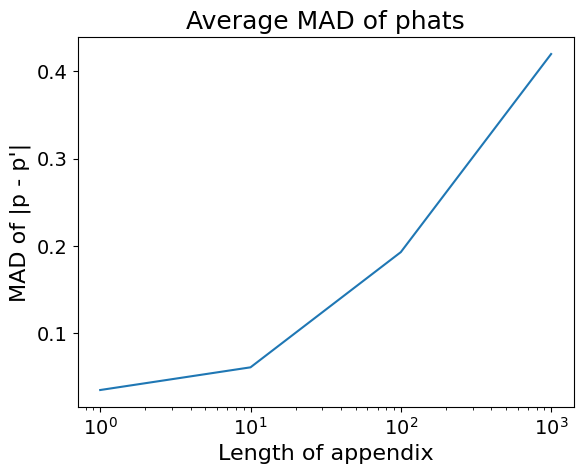

In [10]:
fig, ax = plt.subplots(1,1)
ax.semilogx(length_list[1:], average_abs_distances)
ax.set_title("Average MAD of phats", fontsize=18)
ax.set_ylabel("MAD of |p - p'|", fontsize=16)
ax.set_xlabel("Length of appendix", fontsize=16)
ax.tick_params(labelsize=14)
ax.set_yticks([0.1, 0.2, 0.3, 0.4])

In [27]:
from scipy.spatial import procrustes

strings = list(embeddings_dict[0].keys())
n_perturbations = len(embeddings_dict[1][strings[0]])

length_list = list(np.sort(list(embeddings_dict.keys())))

embedding_distances_dict_stat = {}
embedding_distances_dict_eug = {}

for length in tqdm(length_list[1:]):
    embedding_distances_dict_stat[length] = []
    embedding_distances_dict_eug[length] = []
    
    for mc in range(n_perturbations):
        temp_embeddings = []
        
        for s in embeddings_dict[length]:
            temp_embeddings.append(embeddings_dict[length][s][mc])
            
        temp_embeddings = np.array(temp_embeddings)
        temp_cmds = ClassicalMDS(n_components=2).fit_transform(temp_embeddings)

        # stat
        mtx1, mtx2, d = procrustes(base_cmds[C==0], temp_cmds[C==0])
        embedding_distances_dict_stat[length].append(np.linalg.norm(mtx1 - mtx2))

        # eug
        mtx1, mtx2, d = procrustes(base_cmds[C==1], temp_cmds[C==1])
        embedding_distances_dict_eug[length].append(np.linalg.norm(mtx1 - mtx2))

100%|██████████| 4/4 [00:47<00:00, 11.90s/it]


In [37]:
abs_distances_stat={}
abs_distances_eug={}

average_abs_distances_stat = []
average_abs_distances_eug = []

base_phats = np.array(phats_by_mc[0][0])

for length in length_list[1:]:
    abs_distances_stat[length]={}
    abs_distances_eug[length]={}

    for mc in range(n_perturbations):
        temp_phats = np.array(phats_by_mc[length][mc])
        abs_distances_stat[length][mc] = np.mean(abs(base_phats[C==0] - temp_phats[C==0]))
        abs_distances_eug[length][mc] = np.mean(abs(base_phats[C==1] - temp_phats[C==1]))

    average_abs_distances_stat.append(np.mean(abs_distances_stat[length][mc]))
    average_abs_distances_eug.append(np.mean(abs_distances_eug[length][mc]))

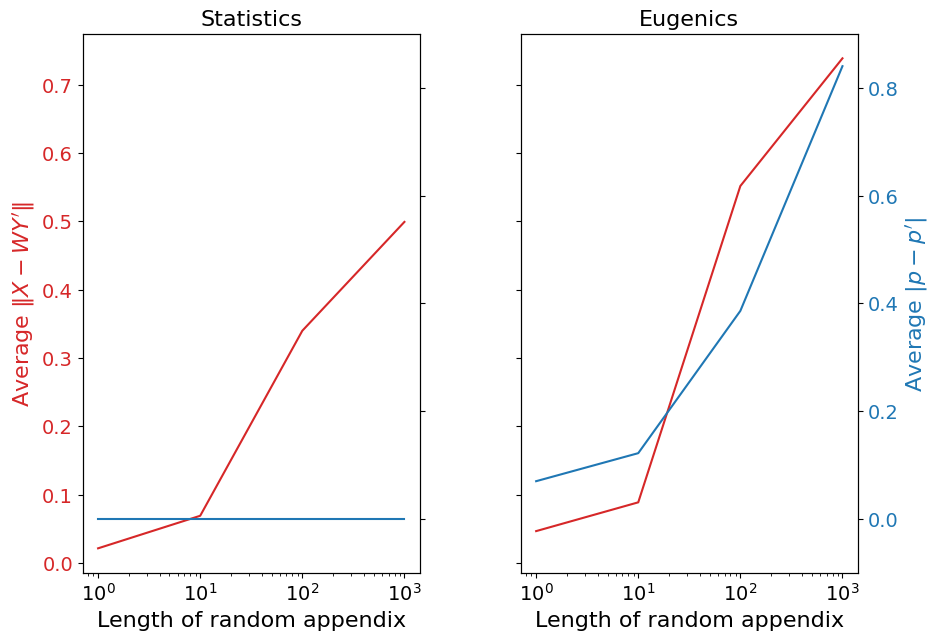

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=True)

average_distances_stat = [np.mean(v) for v in embedding_distances_dict_stat.values()]
average_distances_eug = [np.mean(v) for v in embedding_distances_dict_eug.values()]

ax1 = axes[0]
color='tab:red'
ax1.semilogx(length_list[1:], average_distances_stat, color=color)
ax1.set_xlabel("Length of random appendix", fontsize=16)
ax1.tick_params(labelsize=14, axis='both')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel(r"Average $\| X - WY' \|$", fontsize=16, color=color)
ax1.set_title("Statistics", fontsize=16)

ax2 = axes[1]
ax2.semilogx(length_list[1:], average_distances_eug, color=color)
ax2.set_xlabel("Length of random appendix", fontsize=16)
ax2.tick_params(labelsize=14)
ax2.set_title("Eugenics", fontsize=16)

color='tab:blue'
ax1_r = ax1.twinx()
ax1_r.semilogx(length_list[1:], average_abs_distances_stat, color=color)
ax1_r.tick_params(labelsize=14, labelright=False)
ax1_r.set_ylim([-0.1, 0.9])

ax2_r = ax2.twinx()
ax2_r.semilogx(length_list[1:], average_abs_distances_eug, color=color)
ax2_r.tick_params(labelsize=14)
ax2_r.tick_params(axis='y', labelcolor=color)
ax2_r.set_ylim([-0.1, 0.9])
ax2_r.set_ylabel(r"Average $| p - p'|$", fontsize=16, color=color)

plt.subplots_adjust(wspace=.3)
plt.show()

### Mega Figure

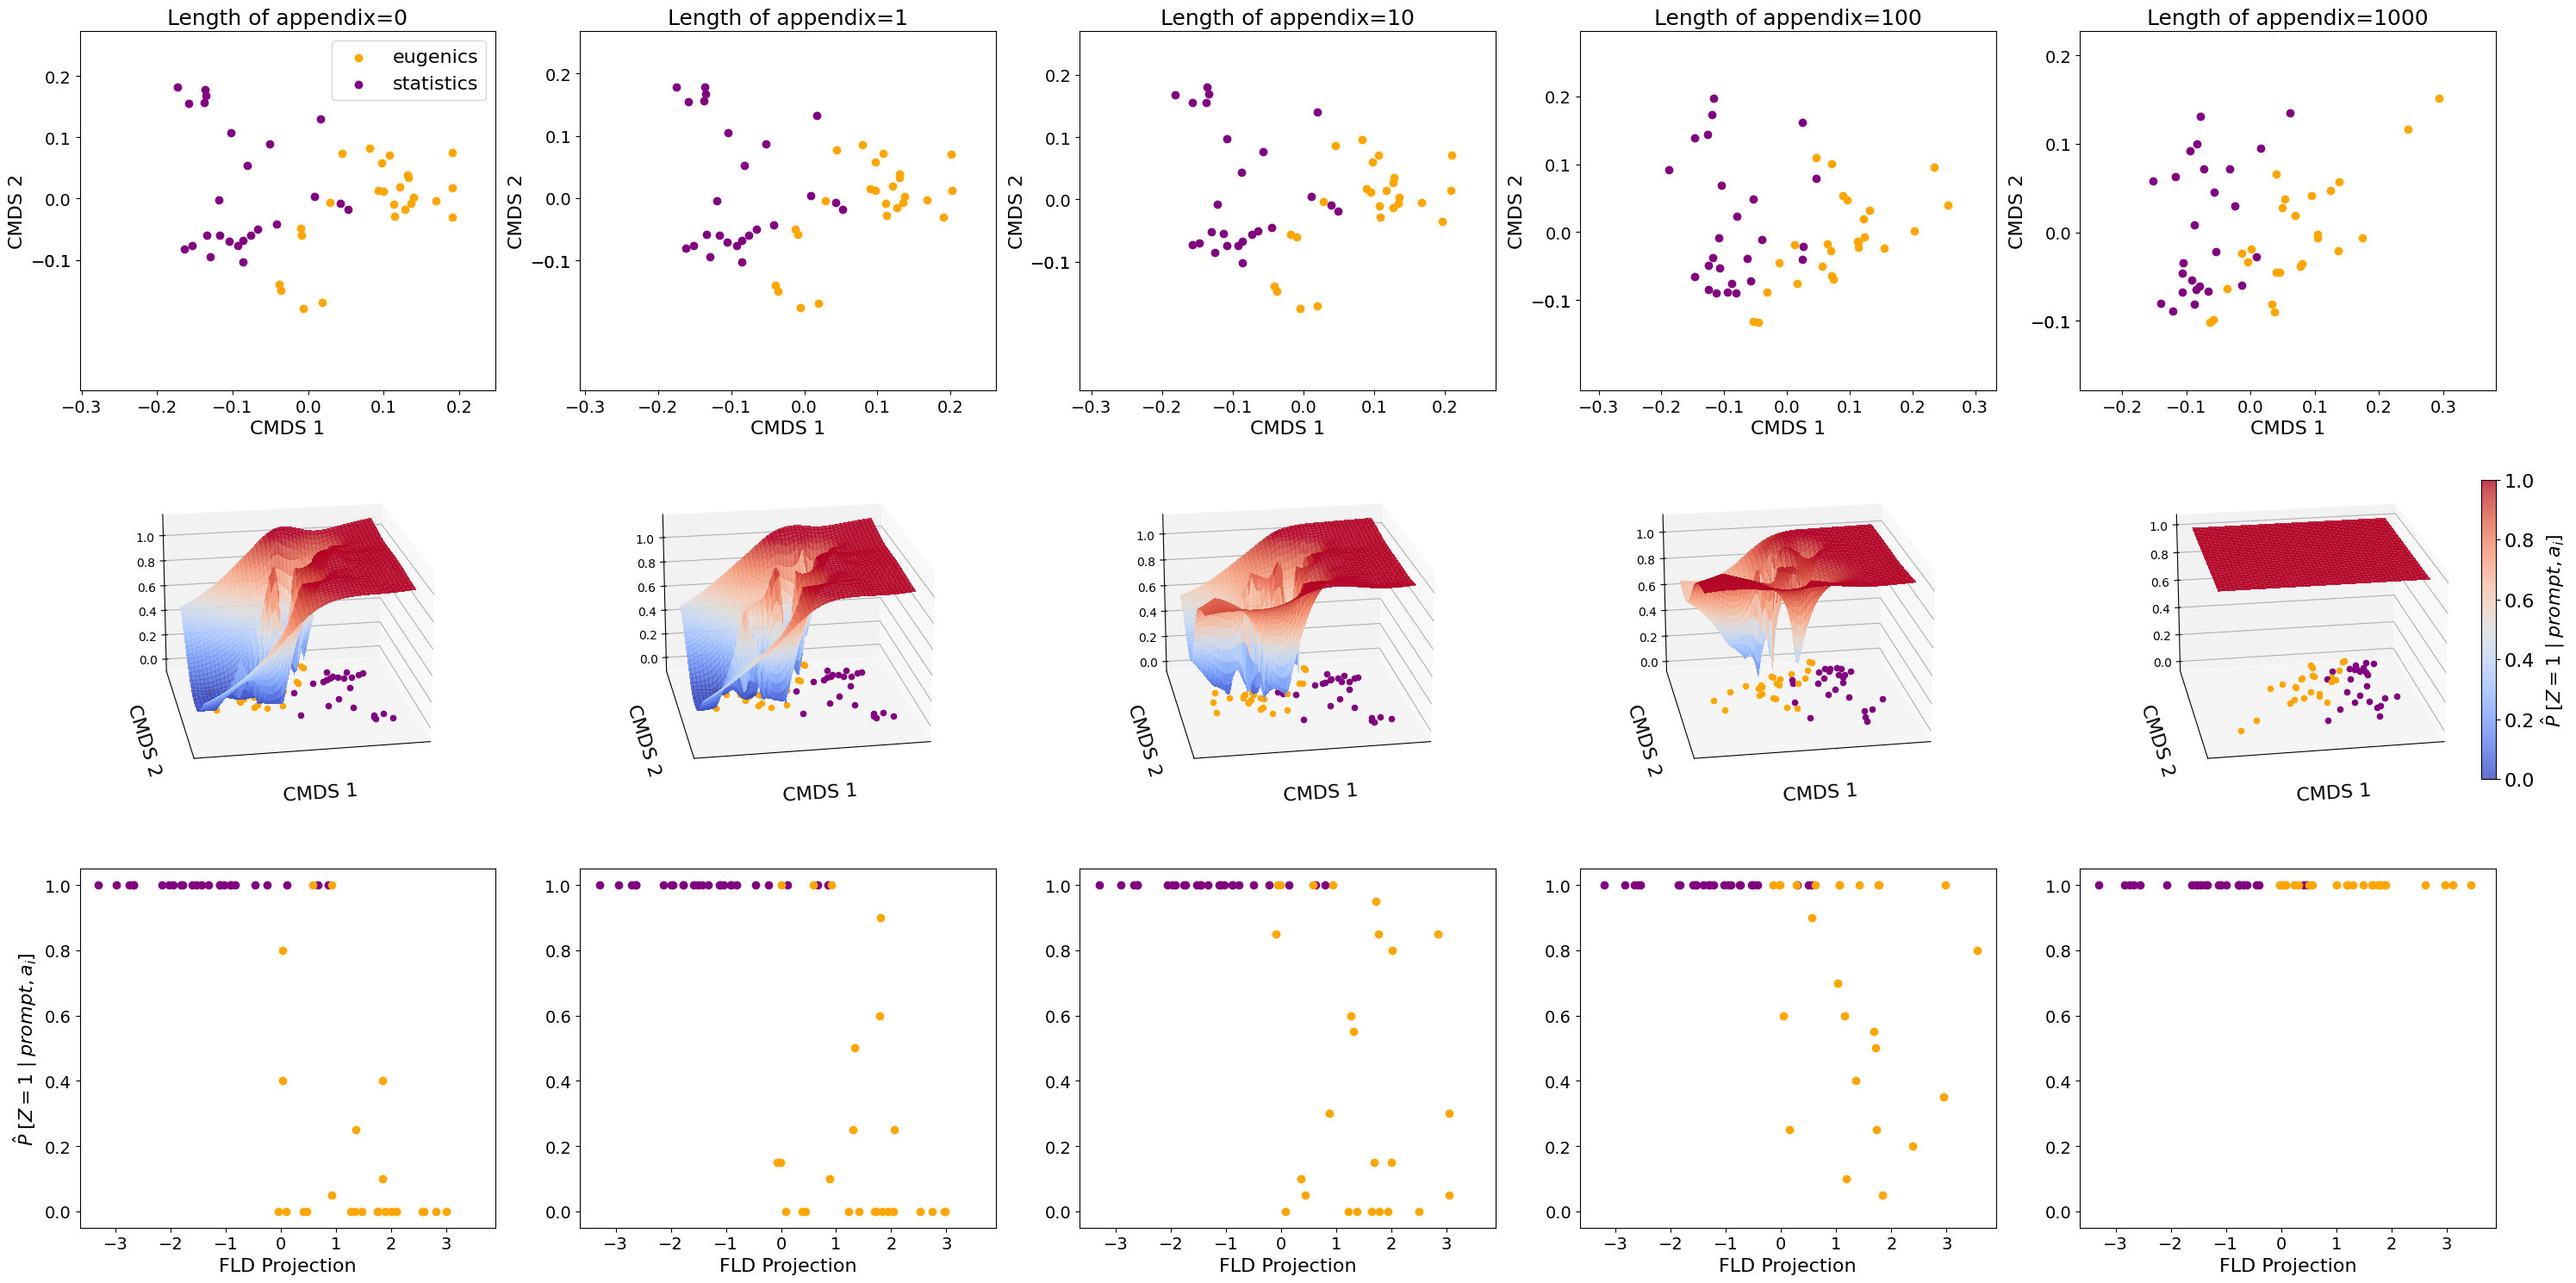

In [10]:
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

fig = plt.figure(figsize=(30, 15))
fig.add_gridspec(3,5, hspace=0)
# fig, axes = plt.subplots(2, 5, figsize=(25,10), sharex=True, sharey=True)

colors = sns.color_palette("Set1", n_colors=2)
colors = ["purple", "orange"]

for ii, p in enumerate(length_list):
    ax = fig.add_subplot(3, 5, ii+1)
    ax.scatter(cmds_embds[p][0][:, 0][C==1], cmds_embds[p][0][:, 1][C == 1], color='orange', label='eugenics')
    ax.scatter(cmds_embds[p][0][:, 0][C==0], cmds_embds[p][0][:, 1][C == 0], color='purple', label='statistics')

    if ii == 0:
        ax.legend(fontsize=16)
    # for i in range(50):
    #     ax.scatter(cmds_embds[p][0][i, 0], cmds_embds[p][0][i, 1], c=colors[C[i]])
    #     # ax.text(cmds_embds[p][0][i, 0], cmds_embds[p][0][i, 1], s=i, fontsize=12, c=colors[C[i]])

    miny = np.min(cmds_embds[p][0][:, 1])
    maxy = np.max(cmds_embds[p][0][:, 1])
    
    minx = np.min(cmds_embds[p][0][:, 0])
    maxx = np.max(cmds_embds[p][0][:, 0])
    
    ax.set_xlim(minx - 0.75*abs(minx), maxx + 0.3*abs(maxx))
    ax.set_ylim(miny - 0.75*abs(miny), maxy + 0.5*abs(maxy))

    ax.set_title(f'Length of appendix={p}', fontsize=18)
    ax.set_ylabel('CMDS 2', fontsize=16)
    ax.set_xlabel('CMDS 1', fontsize=16)

    ax.set_yticks([-.1, 0, -0.1, 0.1, 0.2])
    ax.tick_params(labelsize=14)

for i, p in enumerate(length_list):
    phats = []
        
    phats = np.hstack(phats_by_mc[p][0])
    cmds_embds_p = cmds_embds[p][0]
    
    ax = fig.add_subplot(3, 5, 5+i+1, projection='3d')
    
    xg, yg = np.meshgrid(cmds_embds_p[:, 0], cmds_embds_p[:, 1], indexing='ij')
    interp = RBFInterpolator(cmds_embds_p, phats, kernel='linear', smoothing=0.001)
    
    miny = np.min(cmds_embds_p[:, 1])
    maxy = np.max(cmds_embds_p[:, 1])
    
    minx = np.min(cmds_embds_p[:, 0])
    maxx = np.max(cmds_embds_p[:, 0])
    
    xx = np.linspace(minx - 0.2*abs(minx), maxx + 0.2*abs(maxx), 100)
    yy = np.linspace(miny - 0.2*abs(miny), maxy + 0.2*abs(maxy), 100)
    X, Y = np.meshgrid(xx, yy, indexing='ij')
    
    grid = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)
    vals = interp(grid)
    
    Surface = ax.plot_surface(X, Y, vals.reshape(100, 100), color='m', cmap=cm.coolwarm, antialiased=False, linewidth=0, vmin=0, vmax=1, alpha=0.8)

    cs=['orange', 'purple']
    for j in range(50):
        color=cs[C[j]-1]
        ax.scatter(cmds_embds_p[j, 0], cmds_embds_p[j, 1], 0, s=20, c=color)
    
    
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    if i == len(length_list)-1:
        cbar = fig.colorbar(Surface, ax=ax, fraction=0.036, pad=0.0)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label(label=r'$\hat P \;[Z=1 \mid prompt, a_i]$', size=16)
    # ax.legend(frameon=True, fontsize=12, bbox_to_anchor=(0.3, 0.5))
    ax.set_xlabel("CMDS 1", fontsize=16)
    ax.set_ylabel("CMDS 2", fontsize=16)
    ax.view_init(elev=20, azim=80, roll=0)
    
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_zlim(0, 1)
    
    # ax.set_title(f'Length of appendix={p}', fontsize=18)

for i, p in enumerate(length_list):
    if i == 0:
        ax = fig.add_subplot(3, 5, 10+i+1)
        ax.set_ylabel(r"$\hat P \; [Z = 1 \mid prompt, a_i] $", fontsize=16)
    else:
        ax = fig.add_subplot(3, 5, 10+i+1, sharex=ax, sharey=ax)
    clf = LinearDiscriminantAnalysis()
    pos = clf.fit_transform(cmds_embds[p][0], C).squeeze()
    phats = np.hstack(phats_by_mc[p][0])

    ax.scatter(pos[C==0], phats[C == 0], color='purple', label='statistics')
    ax.scatter(pos[C==1], phats[C == 1], color='orange', label='eugenics')
    ax.set_xlabel("FLD Projection", fontsize=16)
    ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [11]:
fig.savefig('../figures/complete_fig.pdf', bbox_inches='tight')